In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

## my code

In [2]:
import os
import joblib
import time
import timeit
import joblib
import pickle
from ExpressionExpert_Functions import Data_Src_Load, make_DataDir, split_train_test, ExpressionScaler, Sequence_Conserved_Adjusted, Est_Grad_Save, Est_Grad_Feat
from sklearn.model_selection import GroupShuffleSplit

%matplotlib inline

In [3]:
Name_Dict = dict()
with open('config_EcolPtai.txt') as Conf:
    myline = Conf.read().splitlines()
    for line in myline:
        if not line.startswith('#'):
            (key, val) = line.split(':', 1)
            Name_Dict[str(key.strip())] = val.strip()
        

Data_File = Name_Dict['Data_File']
# extract the filename for naming of newly generated files
File_Base = Name_Dict['File_Base']
# the generated files will be stored in a subfolder with custom name
Data_Folder = Name_Dict['Data_Folder']
# column name of expression values
Y_Col_Name = eval(Name_Dict['Y_Col_Name'])
# figure file type
Fig_Type = Name_Dict['Figure_Type']
make_DataDir(Name_Dict)

Already existent data directory  data-PromLib_EcolPtai .


In [4]:
SeqDat = Data_Src_Load(Name_Dict)
SeqDat.head(3)

,Strain ID Ecol,Strain ID Ptai,Sequence,Ecol Promoter Activity,Ptai Promoter Activity,Sequence_label-encrypted,Sequence_letter-encrypted,GC-content
0,SN_rep3 20180122,SynPro35_1,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",0.043,0.014,"[3, 3, 3, 0, 3, 3, 3, 2, 0, 1, 0, 3, 2, 1, 2, ...",TTTATTTGACATGCGTGATGTTTAGAATTATAATTTGGGG,0.3
1,SN_rep3 20180123,SynPro35_2,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",0.033,0.015,"[3, 3, 3, 0, 3, 3, 3, 2, 0, 1, 0, 3, 2, 1, 2, ...",TTTATTTGACATGCGTGATGTTTAGAATTATAATTTGGGG,0.3
2,SN_rep3 20180124,SynPro35_3,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",0.036,0.018,"[3, 3, 3, 0, 3, 3, 3, 2, 0, 1, 0, 3, 2, 1, 2, ...",TTTATTTGACATGCGTGATGTTTAGAATTATAATTTGGGG,0.3


In [5]:
# SeqTrain, SeqTest = split_train_test(SeqDat)
train_size = 1 - eval(Name_Dict['TestRatio'])
# split number '1' because we only use one final test set. Cross validation comes later
gss = GroupShuffleSplit(n_splits=1, train_size=train_size)
X = SeqDat['Sequence']
y = SeqDat[Y_Col_Name]
groups = SeqDat['Sequence_letter-encrypted'].str.upper()
Train_Idx, Test_Idx = list(gss.split(X, y, groups))[0]
SeqTest = SeqDat.iloc[Test_Idx].reset_index(drop=True)
SeqTrain = SeqDat.iloc[Train_Idx].reset_index(drop=True)

TrainTest_Data = {'Train': SeqTrain, 'Test': SeqTest}
TrainTest_File = os.path.join(Data_Folder, '{}_{}_TrainTest-Data.pkl'.format(time.strftime('%Y%m%d'), File_Base))
pickle.dump(TrainTest_Data, open(TrainTest_File, 'wb'))


In [6]:
SeqTrain, Expr_Scaler = ExpressionScaler(SeqTrain, Name_Dict)
# removing non-informative positions where no base diversity exists, base one hot encoding
SeqTrain_Hadj, Positions_removed, PSEntropy = Sequence_Conserved_Adjusted(SeqTrain, Name_Dict, n=1)
SeqOH = SeqTrain_Hadj

In [8]:
Sequence_Samples, Sequence_Positions, Sequence_Bases = np.array(SeqOH['OneHot'].values.tolist()).shape
X = np.array(SeqTrain_Hadj['OneHot'].values.tolist()).reshape(Sequence_Samples,Sequence_Positions*Sequence_Bases)
# adding rows to x for additional features
X = np.append(X,np.array([SeqTrain_Hadj['GC-content']]).T, axis=1)
Y = SeqTrain_Hadj['Ptai Promoter Activity_scaled'].values
print(X.shape, Y.shape)

(258, 89) (258,)


In [9]:
from ExpressionExpert_Functions import list_onehot
X_tmp = list_onehot(list(np.delete(np.array(list(SeqTest['Sequence_label-encrypted'])),Positions_removed, axis=1)))
X_test = np.array(X_tmp).reshape(len(SeqTest.index),-1)
# adding the additional feature, here GC-content
X_test = np.append(X_test,np.array([SeqTest['GC-content']]).T, axis=1)
# activity prediction of training set with best random forest estimator
Y_test = Expr_Scaler['Ptai Promoter Activity_Scaler'].transform(SeqTest['Ptai Promoter Activity'].values.reshape(-1, 1))
print(X.shape, Y.shape)

In [10]:
# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X, Y)
mse = mean_squared_error(Y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.1278


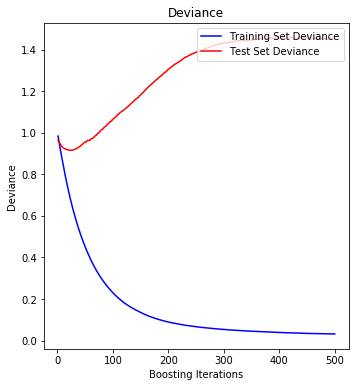

In [11]:
# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(Y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.savefig('GradBoost_Deviance.png', bbox_inches='tight', format='png')

In [ ]:
def list_sequence(IntegerList):
    '''define input values'''
    import numpy as np
    alphabet = 'ACGT'
    int_to_char = dict((i,c) for i,c in enumerate(alphabet))
    SequenceList = list()
    for IntRow in IntegerList:    
        # integer encode input data
        sequence_encoded = [int_to_char[int(myint)] for myint in np.nditer(IntRow)]
        SequenceList.append(sequence_encoded)
    return SequenceList



In [ ]:
# def Est_Grad_Save(SeqOH, Validation_cutoff=.1, Num=100, Y_Col_Name='promoter activity'):
#     '''
#     This function performs gradient search for optimal parameters with shuffle shift and stores it.
    
#     Input:
#         DataArray
#     '''
#     from sklearn.ensemble import RandomForestRegressor
#     from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
# #    from sklearn.metrics import r2_score
#     import numpy as np

#     Sequence_Samples, Sequence_Positions, Sequence_Bases = np.array(SeqOH['OneHot'].values.tolist()).shape
#     X = np.array(SeqOH['OneHot'].values.tolist()).reshape(Sequence_Samples,Sequence_Positions*Sequence_Bases)
#     Y = SeqOH[Y_Col_Name].values
#     groups = SeqOH['Sequence_letter-encrypted']
#     Number_Estimators = np.arange(20,50,2)
#     Max_Features = np.arange(9,15,1)
#     param_grid = [{'bootstrap':[False], 'n_estimators': Number_Estimators, 'max_features': Max_Features}]
#     # Group shuffle split removes groups with identical sequences from the development set
#     # This is more realistic for parameter estimation
#     cv = GroupShuffleSplit(n_splits=Num, test_size=Validation_cutoff, random_state=42)

#     forest_grid = RandomForestRegressor()
#     grid_forest = GridSearchCV(forest_grid, param_grid, cv=cv, n_jobs=-1)
#     grid_forest.fit(X, Y, groups)
    
#     Feature_Importance = np.array(grid_forest.best_estimator_.feature_importances_).reshape(-1,4)

#     return grid_forest, Feature_Importance

In [ ]:
#     # remember to extract the features before rearranging the feature importance to a sequence position matrix form
#     if AddFeat != None:
#         Feat_num = len(AddFeat)
#         Feature_Importance_Nucl = np.array(grid_forest.best_estimator_.feature_importances_[0:-Feat_num]).reshape(-1,4)
#         Feature_Importance_Eng = grid_forest.best_estimator_.feature_importances_[-Feat_num]
#     else:
#         Feature_Importance_Nucl = np.array(grid_forest.best_estimator_.feature_importances_).reshape(-1,4)
#         Feature_Importance_Eng = []